# Ch8 - Tree Based Methods
## Lab: Decision Trees
### 8.3.1 Fitting Classification Trees

In [1]:
# Installing scikit-learn
!pip install -Uqq scikit-learn

<b>Note:</b> The below Github repository provides a collection of 2142 R datasets that can be conveniently accessed directly in Python without the need to download CSV files or libraries to access R library objects.

https://github.com/vincentarelbundock/Rdatasets


The `sklearn.tree` module is a part of the `scikit-learn` library which provides us with several pre-built classes that we can use to create decision tree models. The `sklearn.preprocessing` module provides a collection of tools for data preprocessing and feature engineering. The `sklearn.model_selection` module provides tools for model selection and evaluation, such as splitting a dataset into training and testing sets, cross-validation, and hyperparameter tuning.

In [2]:
# Import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree, DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV


We first use classification trees to analyze the `Carseats` data set. In these data, `Sales` is a continuous variable, and so we begin by recoding it as a binary variable. We will add a new column called `High` to our `carseats` dataframe. The values in the `High` column will determined by whether the values in the `Sales` column are greater than 8. We will then use `map` method to apply a dictionary to the Boolean values. The dictionary maps `True` to the string `Yes` and `False` to the string `No`.

In [3]:
# Load the Carseats Dataset
carseats = pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/ISLR/Carseats.csv'
                       ,index_col=0)

# Add a new categorical variable
carseats['High'] = (carseats['Sales'] > 8).map({True: 'Yes', False: 'No'})

The `DecisionTreeClassifier` in sklearn.tree requires the categorical variables be encoded as integers or one-hot encoded before fitting the decision tree model. To perform one-hot encoding, we use `OneHotEncoder` class from the `sklearn.preprocessing` module for the variable `ShelveLoc`, which creates new binary columns for each unique category in the original column. The `handle_unknown='ignore'` argument in `OneHotEncoder()` specifies to ignore unknown categories that may be present in the dataset. To label encode the binary variables `High` , `Urban`, and `US`, we use `LabelBinarizer` class. This class transforms the binary variable into a column of 1s and 0s, where 1 represents 'Yes' and 0 represents 'No'. The original and encoded categorical column are concatenated using `pd.concat()`. Finally, a decision tree model is created using `DecisionTreeClassifier()` and fitted to the `X` and `High` variables using `.fit()`.

In [4]:
# convert object variable - ShelveLoc to categorical
carseats['ShelveLoc'] = carseats['ShelveLoc'].astype('category') 

# convert High, Urban and US variable to numerical format using label encoding
lb = LabelBinarizer()
carseats['High'] = lb.fit_transform(carseats['High'])
carseats['Urban'] = lb.fit_transform(carseats['Urban'])
carseats['US'] = lb.fit_transform(carseats['US'])

# one-hot encode categorical variable
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_col = pd.DataFrame(encoder.fit_transform(carseats[['ShelveLoc']]).toarray())
encoded_col.columns = encoder.get_feature_names_out(['ShelveLoc'])

# reset the index of the carseats DataFrame
carseats = carseats.reset_index(drop=True)

# concatenate numeric and encoded categorical columns
X = pd.concat([carseats.drop(['Sales', 'High', 'ShelveLoc'], axis=1), encoded_col], axis=1)

# fit decision tree model
tree_carseats = DecisionTreeClassifier()
tree_carseats.fit(X, carseats['High'])

DecisionTreeClassifier()

We use the `export_text` method from the `sklearn.tree` module to print a text summary of the decision tree.

In [5]:
tree_summary = export_text(tree_carseats, feature_names=X.columns.tolist())
print(tree_summary)

|--- ShelveLoc_Good <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- ShelveLoc_Medium <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- ShelveLoc_Medium >  0.50
|   |   |   |   |--- class: 1
|   |   |--- Income >  57.00
|   |   |   |--- Population <= 207.50
|   |   |   |   |--- Age <= 56.50
|   |   |   |   |   |--- Price <= 88.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Price >  88.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- Age >  56.50
|   |   |   |   |   |--- Income <= 102.00
|   |   |   |   |   |   |--- Income <= 67.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- Income >  67.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Income >  102.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- Population >  207.50
|   |   |   |   |--- Income <= 115.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Income >  115.00
|   |   |   |   |   |--- class: 0
|   |-

To find the importance of each feature used in the model to make predictions, we are using `feature_importances_` attribute of a decision tree model in `scikit-learn`.

In [6]:
importances = pd.DataFrame({'feature_name': X.columns, 'importance': tree_carseats.feature_importances_})
importances = importances.sort_values('importance', ascending=False).reset_index(drop=True)
print(importances)

        feature_name  importance
0              Price    0.280456
1     ShelveLoc_Good    0.149813
2             Income    0.109711
3          CompPrice    0.103761
4        Advertising    0.099117
5                Age    0.097821
6      ShelveLoc_Bad    0.054818
7         Population    0.054153
8   ShelveLoc_Medium    0.021703
9                 US    0.016246
10         Education    0.008268
11             Urban    0.004134


We use the `plot_tree` function from the `sklearn.tree` module to display the tree structure. Double click on the tree to zoom in.

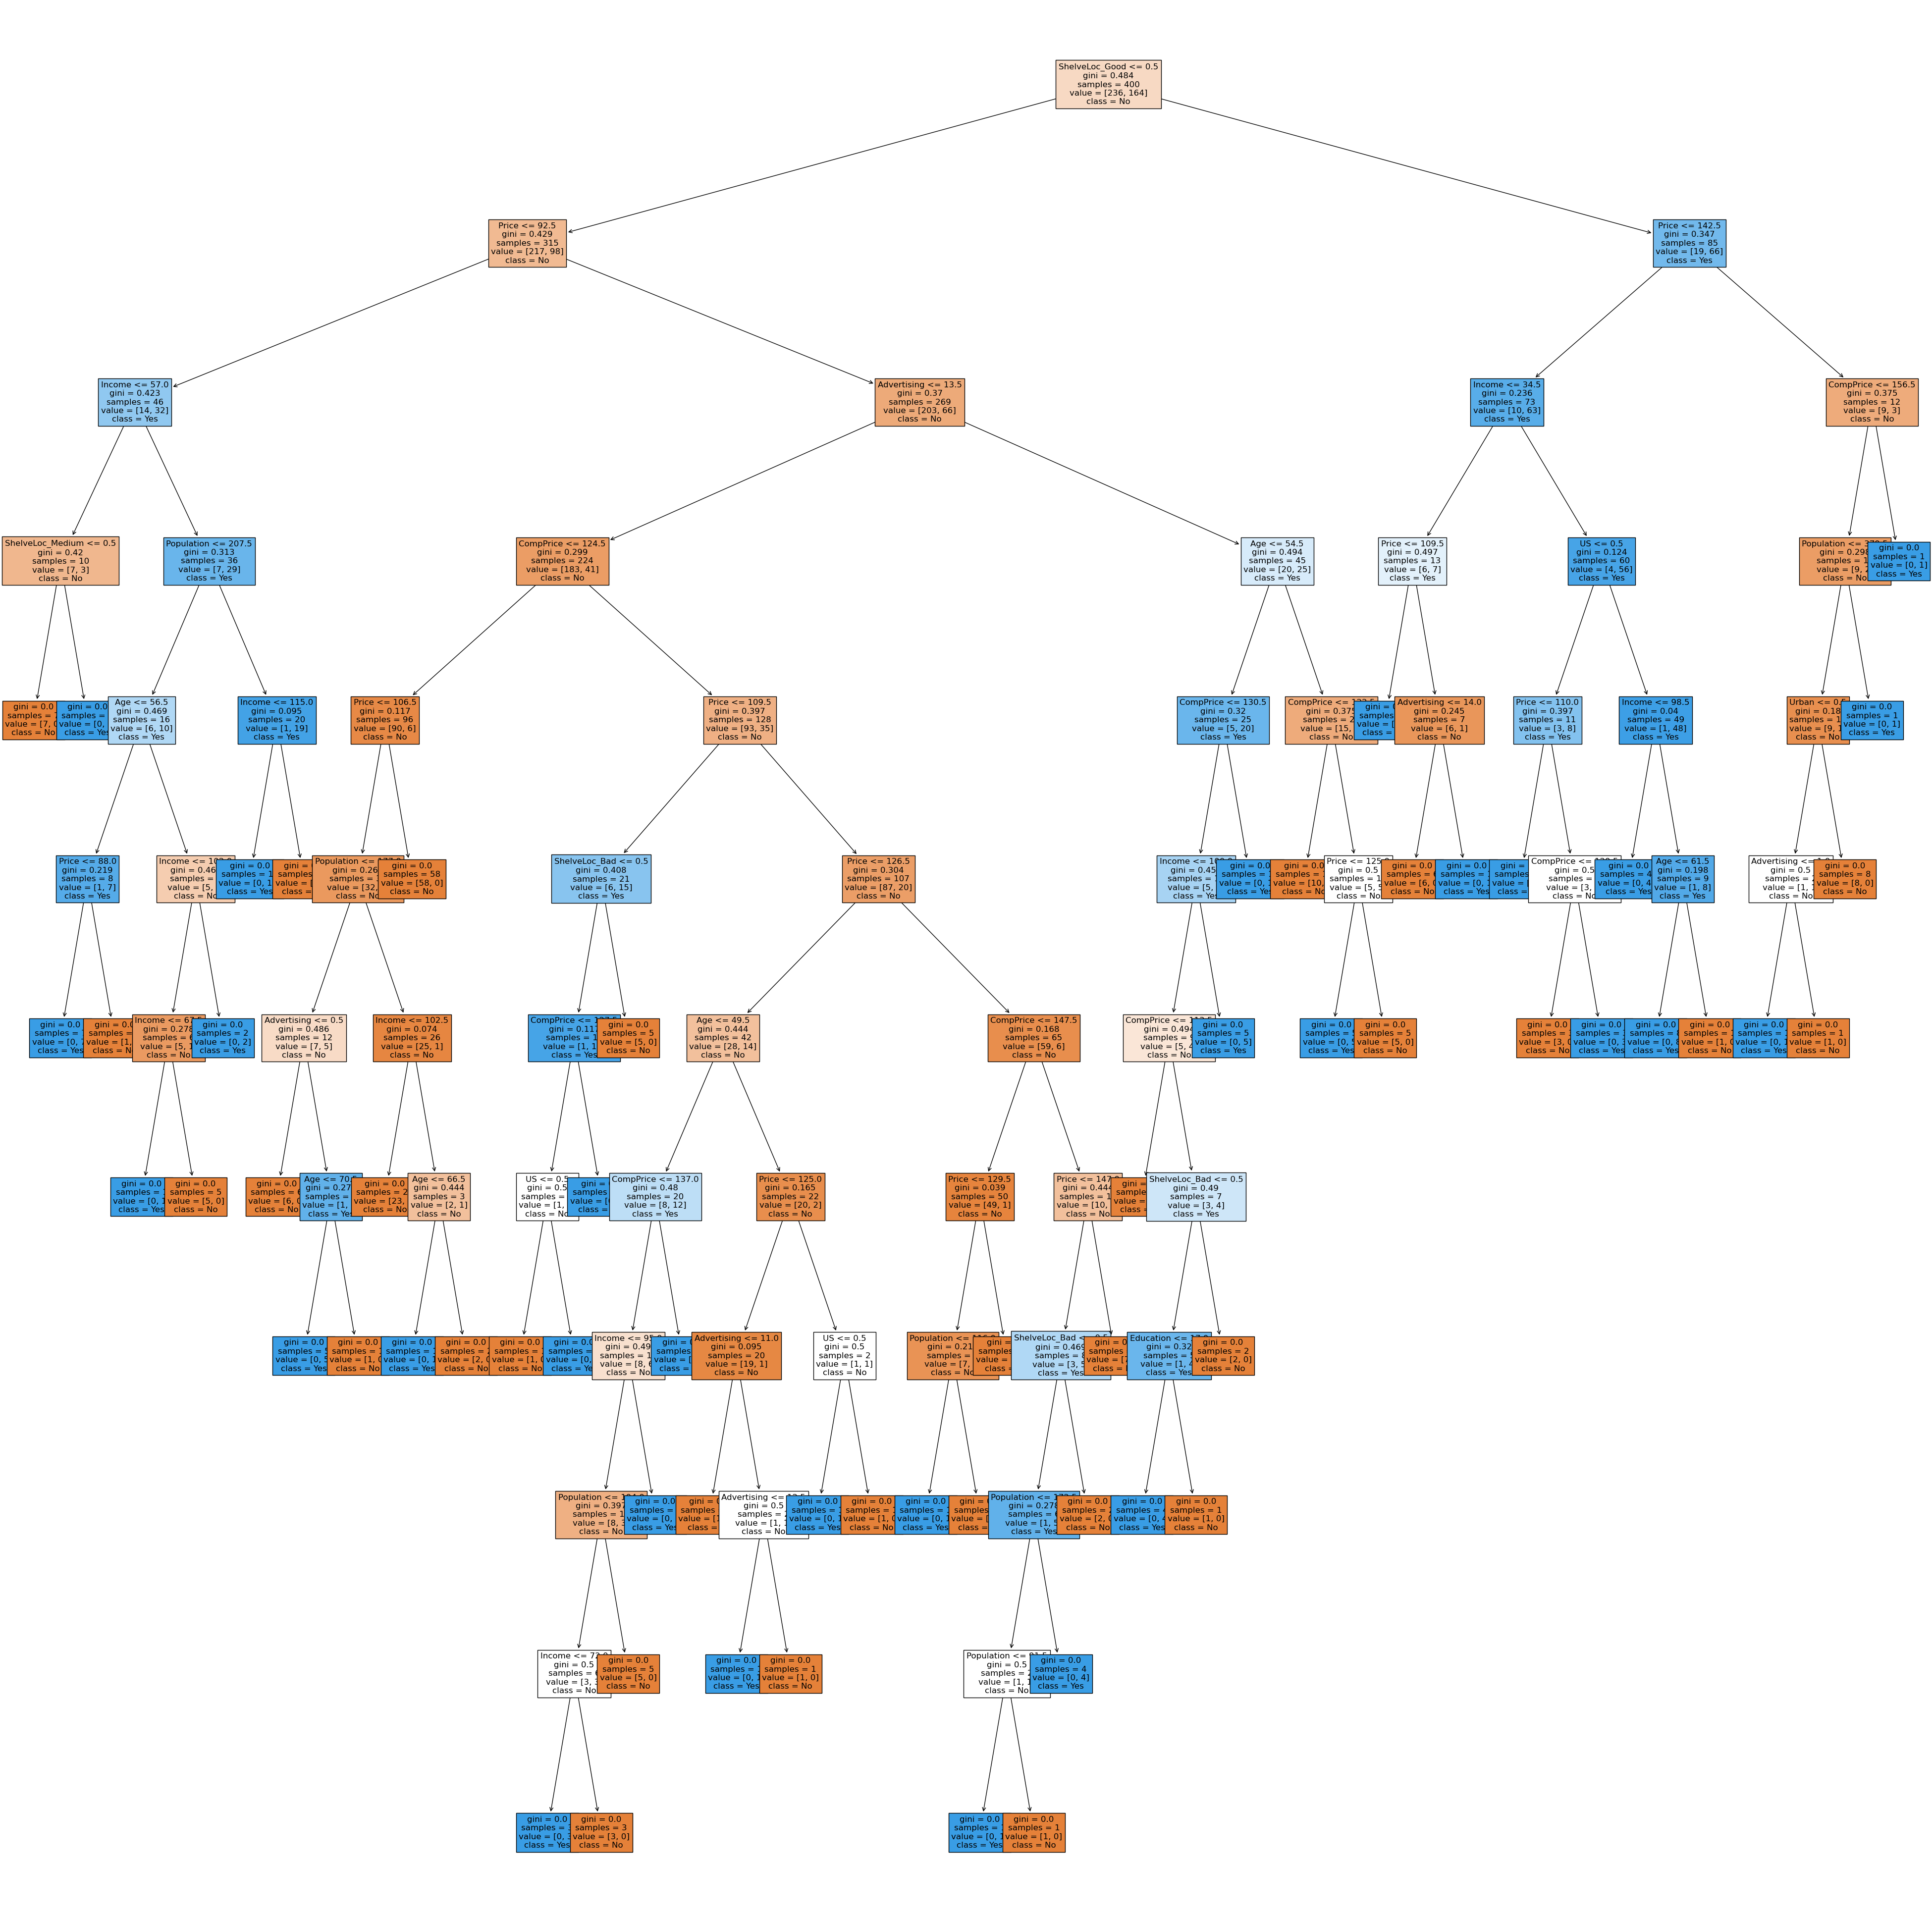

In [7]:
plt.figure(figsize=(50,50))
plot_tree(tree_carseats
          , filled=True
          , feature_names=X.columns
          , class_names=['No', 'Yes']
          , label='all'
          , fontsize=12)
plt.show()

The variable `ShelveLoc_Good` is a binary variable after one-hot encoding, so it can only take on the values 0 or 1. However, the decision tree algorithm treats it as a continuous variable, and therefore can create a split on `ShelveLoc_Good <= 0.5`. This split essentially means that the tree is checking whether the value of `ShelveLoc_Good` is 0 or 1, with values less than or equal to 0.5 being considered as 0 and values greater than 0.5 being considered as 1.

In order to properly evaluate the performance of a classification tree on these data, we must estimate the test error. We split the observations into a training set and a test set uisng `'train_test_split()` function. Then, we build the tree using the training set and evaluate its performance on the test data using the `predict()` function. To summarize the performance of our model, we create a contingency table using the `crosstab()` function from the Pandas library. Finally, we use the `score()` method in `scikit-learn` to obtain the mean accuracy on the given test data and labels. Our approach results in correct predictions for approximately 74% of the locations in the test dataset.

In [8]:
# Split the Data between test and train
X_train, X_test, y_train, y_test = train_test_split(X, carseats['High']
                                                    , train_size = 0.5, test_size = 0.5
                                                    , random_state = 2)
# fit decision tree model
tree_carseats = DecisionTreeClassifier()
tree_carseats.fit(X_train, y_train)

# predict on test data
tree_pred = tree_carseats.predict(X_test)

# create confusion matrix
confusion_matrix = pd.crosstab(index=tree_pred, columns=y_test, rownames=[''])
print(confusion_matrix)

High   0   1
            
0     96  17
1     30  57


In [9]:
# Calculate the accuracy of the decision tree on the test data
accuracy = tree_carseats.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 76.50%


Next, we consider whether pruning the tree might lead to improved results. We perform a grid search to determine the optimal tree size for the decision tree model. The parameter `max_leaf_nodes` is varied from 2 to 20 using the `range()` function and a dictionary params is created with this parameter. The `GridSearchCV()` function is then used with the `tree_carseats` model and the params dictionary to perform cross-validation with 10 folds. The `fit()` function is called on this `GridSearchCV` object with the training data X_train and y_train as input to train the model. The `cv_results_` attribute of the `GridSearchCV` object is used to store the results of the cross-validation. `best_params_` is used to obtain the optimal value of `max_leaf_nodes` and `best_score_` is used to obtain the accuracy score achieved by the best model.

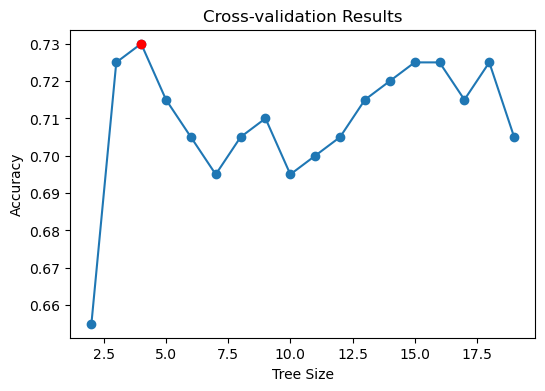

In [10]:
# fit decision tree model
tree_carseats = DecisionTreeClassifier(random_state=7)
tree_carseats.fit(X_train, y_train)

# cross-validation to determine optimal tree size
params = {'max_leaf_nodes': range(2, 20)}  
cv_carseats = GridSearchCV(tree_carseats, params, cv=10)
cv_carseats.fit(X_train, y_train)
cv_results = cv_carseats.cv_results_

# find the best score for max leaf nodes
best_size = cv_carseats.best_params_['max_leaf_nodes']
best_score = cv_carseats.best_score_

# plot results of cross-validation
plt.figure(figsize=(6, 4))
plt.plot(cv_results["param_max_leaf_nodes"], cv_results["mean_test_score"], 'o-')
plt.plot(best_size, best_score, 'ro-')
plt.xlabel('Tree Size')
plt.ylabel('Accuracy')
plt.title('Cross-validation Results');


We use the `DecisionTreeClassifier()` function with the `max_leaf_nodes` argument set to `best_size`, which is the optimal value obtained from cross-validation. The `random_state argument` is set to 7 to ensure reproducibility of the results. Next, the model is fit on the training data and plotted, resulting in a more interpretable tree.

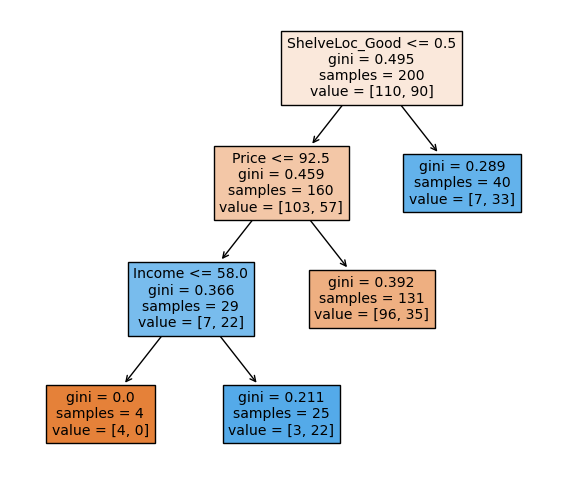

In [11]:
# prune tree using optimal size
prune_carseats = DecisionTreeClassifier(max_leaf_nodes=best_size, random_state=7)
prune_carseats.fit(X_train, y_train)

# plot pruned tree
plt.figure(figsize=(7,6))
plt.title('Pruned Tree')
plot_tree(prune_carseats, feature_names=X_train.columns, filled=True);

How well does this pruned tree perform on the test data set? Once again, we apply the `predict()` function.

In [12]:
# obtain predicted labels for test set
y_pred = prune_carseats.predict(X_test)

# create confusion matrix
confusion_matrix = pd.crosstab(index=y_pred, columns=y_test, rownames=[''])
print(confusion_matrix)

High    0   1
             
0     110  35
1      16  39


In [13]:
# Calculate the accuracy of the decision tree on the test data
accuracy = prune_carseats.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 74.50%


After pruning, the classification accuracy has slightly improved, with 74.50% of the test observations correctly classified. You might want to consider tuning the hyperparameters such as `max_depth`, `min_samples_split`, or `min_samples_leaf` to improve the performance of the decision tree model. 

###  8.3.2 Fitting Regression Trees

Here we fit a regression tree to the Boston data set. First, we create a training set, and fit the tree to the training data. We use `DecisionTreeRegressor()` class in `scikit-learn` to build our model. While the `DecisionTreeClassifier()` is used for predicting classes, the `DecisionTreeRegressor()` is used for predicting continuous values. In order to create a more interpretable tree, we set the `max_leaf_nodes` parameter to 10.

In [14]:
# Load the Carseats Dataset
boston = pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/MASS/Boston.csv'
                       ,index_col=0)

# Split the Data between test and train
X_train, X_test, y_train, y_test =  train_test_split(boston.drop('medv',axis = 1)
                                                 ,boston['medv']
                                                 ,train_size = 0.5, test_size = 0.5
                                                 ,random_state = 1)


# fit decision tree model
tree_boston = DecisionTreeRegressor(max_leaf_nodes=10,random_state = 1)
tree_boston.fit(X_train,y_train)

DecisionTreeRegressor(max_leaf_nodes=10, random_state=1)

Lets look at the summary of the decision tree and the importance of each feature used in the model to make predictions. It indicates that only four of the variables have been used in constructing the tree.

In [15]:
tree_summary = export_text(tree_boston, feature_names=X_train.columns.tolist())
print(tree_summary)

|--- lstat <= 9.76
|   |--- rm <= 7.51
|   |   |--- dis <= 1.56
|   |   |   |--- value: [50.00]
|   |   |--- dis >  1.56
|   |   |   |--- rm <= 6.80
|   |   |   |   |--- rm <= 6.13
|   |   |   |   |   |--- value: [20.92]
|   |   |   |   |--- rm >  6.13
|   |   |   |   |   |--- value: [25.59]
|   |   |   |--- rm >  6.80
|   |   |   |   |--- value: [32.42]
|   |--- rm >  7.51
|   |   |--- value: [45.16]
|--- lstat >  9.76
|   |--- lstat <= 20.19
|   |   |--- lstat <= 14.80
|   |   |   |--- rm <= 6.69
|   |   |   |   |--- value: [20.25]
|   |   |   |--- rm >  6.69
|   |   |   |   |--- value: [27.80]
|   |   |--- lstat >  14.80
|   |   |   |--- value: [17.17]
|   |--- lstat >  20.19
|   |   |--- crim <= 8.30
|   |   |   |--- value: [15.09]
|   |   |--- crim >  8.30
|   |   |   |--- value: [9.46]



In [16]:
importances = pd.DataFrame({'feature_name': X_train.columns, 'importance': tree_boston.feature_importances_})
importances = importances.sort_values('importance', ascending=False).reset_index(drop=True)
print(importances)

   feature_name  importance
0         lstat    0.639371
1            rm    0.257764
2           dis    0.084297
3          crim    0.018568
4            zn    0.000000
5         indus    0.000000
6          chas    0.000000
7           nox    0.000000
8           age    0.000000
9           rad    0.000000
10          tax    0.000000
11      ptratio    0.000000
12        black    0.000000


We now plot the tree.

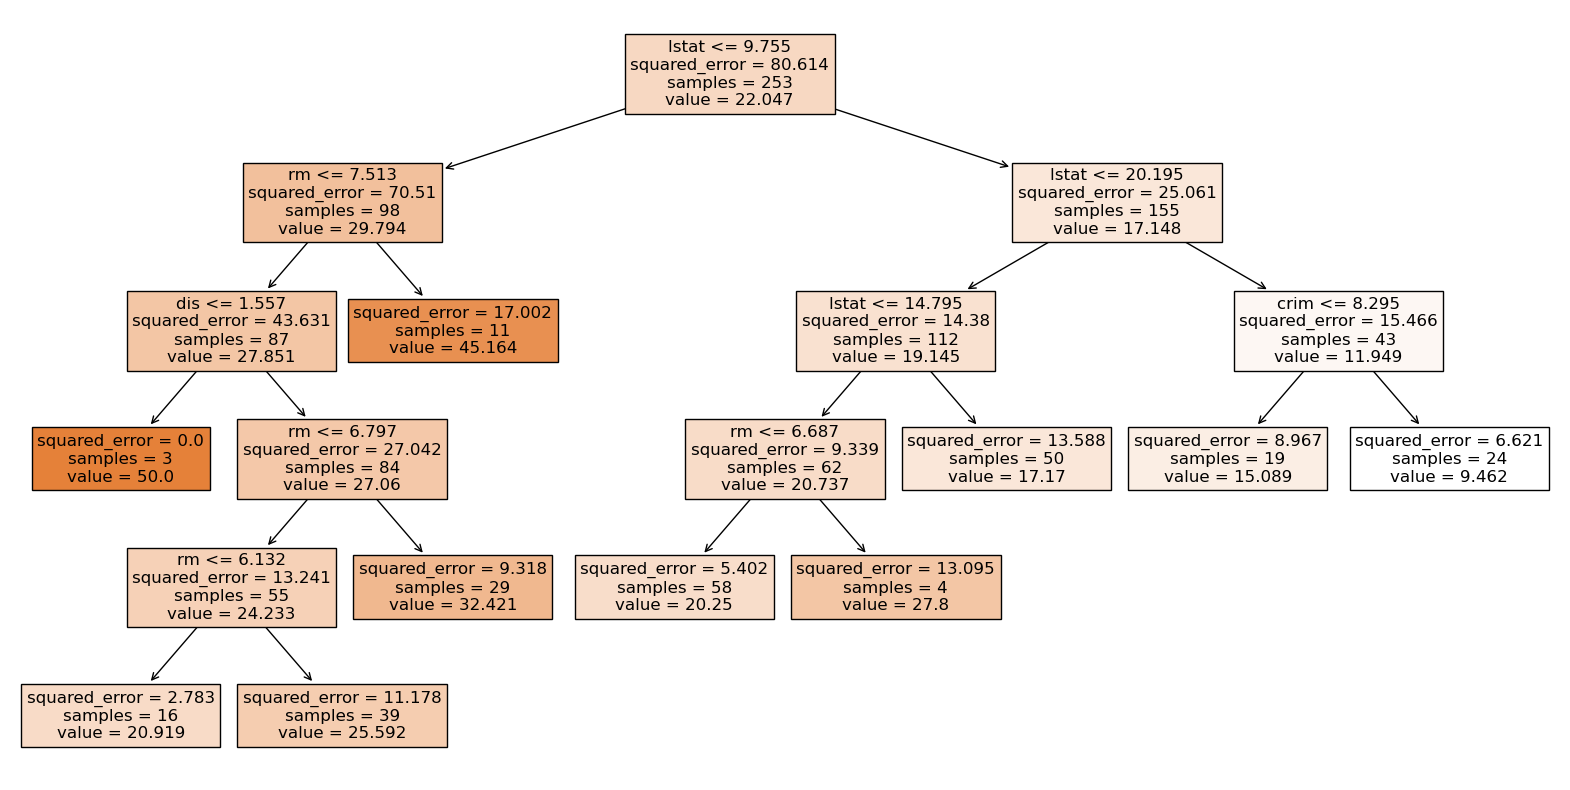

In [17]:
plt.figure(figsize=(20,10))
plot_tree(tree_boston
          , filled=True
          , feature_names=X_train.columns
          , label='all'
          , fontsize=12)
plt.show()

The variable `lstat` measures the percentage of individuals with {lower socioeconomic status}, while the variable `rm` corresponds to the average number of rooms. The tree suggests that homes in areas with fewer individuals with lower socioeconomic status and more rooms tend to have higher median values. Our approach results in correct predictions for approximately 80.31%.

In [18]:
# Calculate the accuracy of the decision tree on the test data
accuracy = tree_boston.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy*100))


Accuracy: 80.31%


Lets check whether pruning the tree will improve performance.

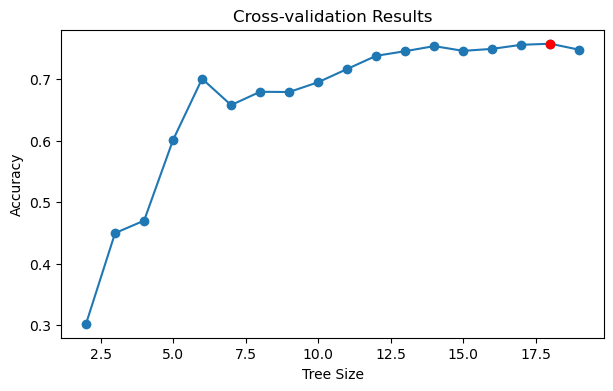

In [19]:
# fit decision tree model
tree_boston = DecisionTreeRegressor(random_state = 1)
tree_boston.fit(X_train, y_train)

# cross-validation to determine optimal tree size
params = {'max_leaf_nodes': range(2, 20)}  
cv_boston = GridSearchCV(tree_boston, params, cv=20)
cv_boston.fit(X_train, y_train)
cv_results = cv_boston.cv_results_

# find the best score for max leaf nodes
best_size = cv_boston.best_params_['max_leaf_nodes']
best_score = cv_boston.best_score_

# plot results of cross-validation
plt.figure(figsize=(7, 4))
plt.plot(cv_results["param_max_leaf_nodes"].data, cv_results["mean_test_score"], 'o-')
plt.plot(best_size, best_score, 'ro-')
plt.xlabel('Tree Size')
plt.ylabel('Accuracy')
plt.title('Cross-validation Results');

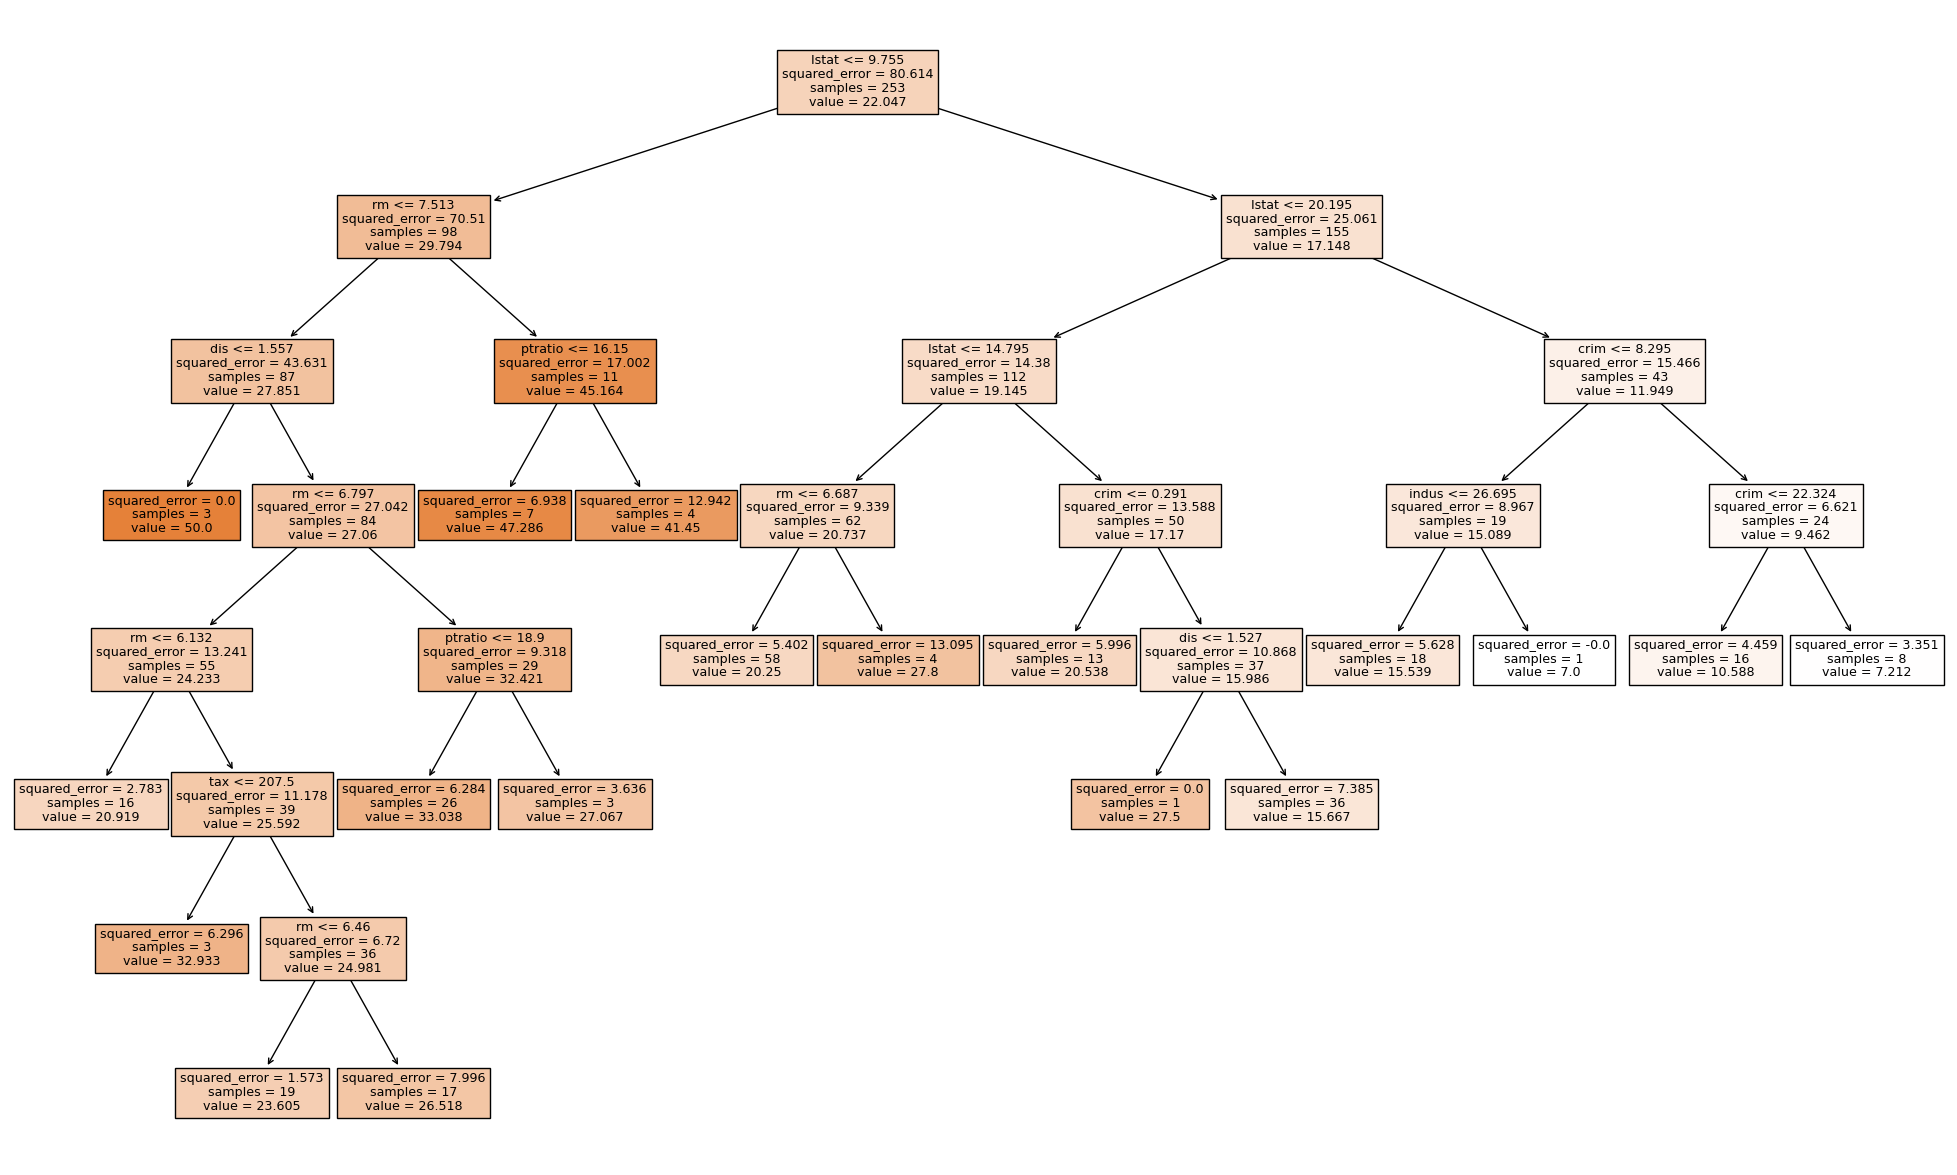

In [20]:
# prune tree using optimal size
prune_boston = DecisionTreeRegressor(random_state = 1, max_leaf_nodes = best_size)
prune_boston.fit(X_train, y_train)

# plot pruned tree
plt.figure(figsize=(25,15))
plt.title('Pruned Tree')
plot_tree(prune_boston, feature_names=X_train.columns, filled=True);

In keeping with the cross-validation results, we use the pruned tree to make predictions on the test set.

In [21]:
# Calculate the accuracy of the decision tree on the test data
accuracy = prune_boston.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 80.88%


We can observe that a complex tree with 18 leaf nodes didn't produce significantly better results than a simpler tree with 10 leaf nodes.

In [22]:
# Calculate MSE
MSE = ((y_test - prune_boston.predict(X_test))**2).mean()
print(MSE)

16.77878226171658


An MSE of 16.78 shows that we are about 4.1 units away from the actual values. So, the model has an average error of about $4,100 when predicting the median home value (medv) in Boston.